<a href="https://colab.research.google.com/github/ZakariaBOUZIT/random.datascience/blob/main/upwork_decisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **imports and utilities**

In [1]:
import numpy
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
####################################
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#### utilities.

def test_unique_class(data):
    if len(numpy.unique(data[:, -1])) == 1: return 1
    else:return 0
def classifyData(data):
    uniqueClasses, uniqueClassesCounts = numpy.unique(data[:, -1], return_counts = True)
    return uniqueClasses[uniqueClassesCounts.argmax()]

# **data processing**

In [3]:
dataFrame = pd.read_csv("gdrive/MyDrive/ttt.data")
dataFrame

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,x,x,x,x,o,o,o,x,o,positive
1,x,x,x,x,o,o,o,o,x,positive
2,x,x,x,x,o,o,o,b,b,positive
3,x,x,x,x,o,o,b,o,b,positive
4,x,x,x,x,o,o,b,b,o,positive
...,...,...,...,...,...,...,...,...,...,...
952,o,x,x,x,o,o,o,x,x,negative
953,o,x,o,x,x,o,x,o,x,negative
954,o,x,o,x,o,x,x,o,x,negative
955,o,x,o,o,x,x,x,o,x,negative


In [4]:
#data conversion and scaling.

dataFrame['x'],x = pd.factorize(dataFrame['x'], sort=True)
dataFrame['x.1'],x1 = pd.factorize(dataFrame['x.1'], sort=True)
dataFrame['x.2'],x2 = pd.factorize(dataFrame['x.2'], sort=True)
dataFrame['x.3'],x3 = pd.factorize(dataFrame['x.3'], sort=True)
dataFrame['o'],o = pd.factorize(dataFrame['o'], sort=True)
dataFrame['o.1'],o1 = pd.factorize(dataFrame['o.1'], sort=True)
dataFrame['x.4'],x4 = pd.factorize(dataFrame['x.4'], sort=True)
dataFrame['o.2'],o2 = pd.factorize(dataFrame['o.2'], sort=True)
dataFrame['o.3'],o3 = pd.factorize(dataFrame['o.3'], sort=True)
dataFrame['positive'],classes = pd.factorize(dataFrame['positive'], sort=True)
#min-max normalization
df = dataFrame.drop('positive', axis=1)
df_norm = (df-df.min())/(df.max()-df.min())
df_norm = pd.concat((df_norm, dataFrame['positive']), 1)
dataFrame = df_norm
dataFrame

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,1.0,1.0,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1
1,1.0,1.0,1.0,1.0,0.5,0.5,0.5,0.5,1.0,1
2,1.0,1.0,1.0,1.0,0.5,0.5,0.5,0.0,0.0,1
3,1.0,1.0,1.0,1.0,0.5,0.5,0.0,0.5,0.0,1
4,1.0,1.0,1.0,1.0,0.5,0.5,0.0,0.0,0.5,1
...,...,...,...,...,...,...,...,...,...,...
952,0.5,1.0,1.0,1.0,0.5,0.5,0.5,1.0,1.0,0
953,0.5,1.0,0.5,1.0,1.0,0.5,1.0,0.5,1.0,0
954,0.5,1.0,0.5,1.0,0.5,1.0,1.0,0.5,1.0,0
955,0.5,1.0,0.5,0.5,1.0,1.0,1.0,0.5,1.0,0


# **random partition into training and testing data**

In [5]:
#data split.

def trainTestSplit(dataFrame, testSize):
    if isinstance(testSize, float):
        testSize = round(testSize * len(dataFrame))
    indices = dataFrame.index.tolist()
    testIndices = random.sample(population = indices, k = testSize)
    dataFrameTest = dataFrame.loc[testIndices]
    dataFrameTrain = dataFrame.drop(testIndices)
    return dataFrameTrain, dataFrameTest

In [6]:
dataFrameTrain, dataFrameTest = trainTestSplit(dataFrame, testSize = 0.25)
print('data size: {} row'.format(len(dataFrame)+1))
print('train data size: {} row'.format(len(dataFrameTrain)+1))
print('test data size: {} row'.format(len(dataFrameTest)+1))

data size: 958 row
train data size: 719 row
test data size: 240 row


# **decision tree classification algorithm**

In [26]:
#### build tree.

def getPotentialSplits(data, randomAttributes):
    potentialSplits = {}
    _, columns = data.shape
    columnsIndices = list(range(columns - 1)) #exclude label column
    if randomAttributes != None  and len(randomAttributes) <= len(columnsIndices): columnsIndices = randomAttributes
    for column in columnsIndices:
        values = data[:, column]
        uniqueValues = numpy.unique(values)
        if len(uniqueValues) == 1:
            potentialSplits[column] = uniqueValues
        else:
            potentialSplits[column] = []
            for i in range(len(uniqueValues)):
                if i != 0:
                    currentValue = uniqueValues[i]
                    previousValue = uniqueValues[i - 1]
                    potentialSplits[column].append((currentValue + previousValue) / 2)
    return potentialSplits

def splitData(data, splitColumn, splitValue):
    splitColumnValues = data[:, splitColumn]
    return data[splitColumnValues <= splitValue], data[splitColumnValues > splitValue]

def calculateEntropy(data):
    _, uniqueClassesCounts = numpy.unique(data[:, -1], return_counts = True)
    probabilities = uniqueClassesCounts / uniqueClassesCounts.sum()
    return sum(probabilities * -numpy.log2(probabilities))

def calculateOverallEntropy(dataBelow, dataAbove):
    pDataBelow = len(dataBelow) / (len(dataBelow) + len(dataAbove))
    pDataAbove = len(dataAbove) / (len(dataBelow) + len(dataAbove))
    return pDataBelow * calculateEntropy(dataBelow) + pDataAbove * calculateEntropy(dataAbove)

def determineBestSplit(data, potentialSplits, randomSplits = None):
    overallEntropy = 9999
    bestSplitColumn = 0
    bestSplitValue = 0
    if randomSplits == None:
        for splitColumn in potentialSplits:
            for splitValue in potentialSplits[splitColumn]:
                dataBelow, dataAbove = splitData(data, splitColumn, splitValue)
                currentOverallEntropy = calculateOverallEntropy(dataBelow, dataAbove)
                if currentOverallEntropy <= overallEntropy:
                    ### information gain mesure.              
                    #print('node impurity :',currentOverallEntropy)
                    overallEntropy = currentOverallEntropy
                    bestSplitColumn = splitColumn
                    bestSplitValue = splitValue
    else:
        for i in range(randomSplits):
            randomSplitColumn = random.choice(list(potentialSplits))
            randomSplitValue = random.choice(potentialSplits[randomSplitColumn])
            dataBelow, dataAbove = splitData(data, randomSplitColumn, randomSplitValue)
            currentOverallEntropy = calculateOverallEntropy(dataBelow, dataAbove)
            if currentOverallEntropy <= overallEntropy:
                overallEntropy = currentOverallEntropy
                bestSplitColumn = randomSplitColumn
                bestSplitValue = randomSplitValue
    return bestSplitColumn, bestSplitValue

def buildDecisionTree(dataFrame, currentDepth = 0, minSampleSize = 2, maxDepth = 1000, randomAttributes = None, randomSplits = None):
    if currentDepth == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = dataFrame.columns
        data = dataFrame.values
        if randomAttributes != None and randomAttributes <= len(COLUMN_HEADERS) - 1:
            randomAttributes = random.sample(population = list(range(len(COLUMN_HEADERS) - 1)), k = randomAttributes)
        else:
            randomAttributes = None
    else:
        data = dataFrame
    if test_unique_class(data) or len(data) < minSampleSize or currentDepth == maxDepth:
        return classifyData(data)
    else:
        currentDepth += 1
        potentialSplits = getPotentialSplits(data, randomAttributes)
        splitColumn, splitValue = determineBestSplit(data, potentialSplits, randomSplits)
        dataBelow, dataAbove = splitData(data, splitColumn, splitValue)
        if len(dataBelow) == 0 or len(dataAbove) == 0:
            return classifyData(data)
        else:
            question = str(COLUMN_HEADERS[splitColumn]) + " <= " + str(splitValue)
            decisionSubTree = {question: []}
            yesAnswer = buildDecisionTree(dataBelow, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits)
            noAnswer = buildDecisionTree(dataAbove, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits)
            if yesAnswer == noAnswer:
                decisionSubTree = yesAnswer
            else:
                decisionSubTree[question].append(yesAnswer)
                decisionSubTree[question].append(noAnswer)
            return decisionSubTree

In [27]:
### predictions, error and class type.

def classifySample(sample, decisionTree):
    if not isinstance(decisionTree, dict):
        return decisionTree
    question = list(decisionTree.keys())[0]
    attribute, value = question.split(" <= ")
    if sample[attribute] <= float(value):
        answer = decisionTree[question][0]
    else:
        answer = decisionTree[question][1]
    return classifySample(sample, answer)

def decisionTreePredictions(dataFrame, decisionTree):
    predictions = dataFrame.apply(classifySample, axis = 1, args = (decisionTree,))
    return predictions

def calculateAccuracy(predictedResults, category):
    resultCorrect = predictedResults == category
    return resultCorrect.mean()

def calculateError(predictedResults, category):
    resultFalse = predictedResults != category
    return resultFalse.mean()

# **Main : model trainning and evaluation**

In [28]:
i = 1
errorTest = 1
totalErrorTrain = []
totalErrorTest = []
accepted_error = 0.15
while errorTest > accepted_error:
    decisionTree = buildDecisionTree(dataFrameTrain, maxDepth = i)

    decisionTreeTrainResults = decisionTreePredictions(dataFrameTrain, decisionTree)
    errorTrain = calculateError(decisionTreeTrainResults, dataFrameTrain.iloc[:, -1])
    totalErrorTrain.append(errorTrain)
    
    decisionTreeTestResults = decisionTreePredictions(dataFrameTest, decisionTree)
    errorTest = calculateError(decisionTreeTestResults, dataFrameTest.iloc[:, -1])
    totalErrorTest.append(errorTest)

    print("----------------------------------------------- iteration = {}: ----------------------------------------------- ".format(i))
    print("Optimistic error rate of the training data = {0:.2f}, ".format(errorTrain), end = "\t")
    print("a generalization error rate of the test data = {0:.2f}, ".format(errorTest))
    print("---------------------------------------------------------------------------------------------------------------")
    print("\n")
    i += 1

----------------------------------------------- iteration = 1: ----------------------------------------------- 
Optimistic error rate of the training data = 0.35, 	a generalization error rate of the test data = 0.33, 
---------------------------------------------------------------------------------------------------------------


----------------------------------------------- iteration = 2: ----------------------------------------------- 
Optimistic error rate of the training data = 0.31, 	a generalization error rate of the test data = 0.28, 
---------------------------------------------------------------------------------------------------------------


----------------------------------------------- iteration = 3: ----------------------------------------------- 
Optimistic error rate of the training data = 0.29, 	a generalization error rate of the test data = 0.31, 
---------------------------------------------------------------------------------------------------------------


----

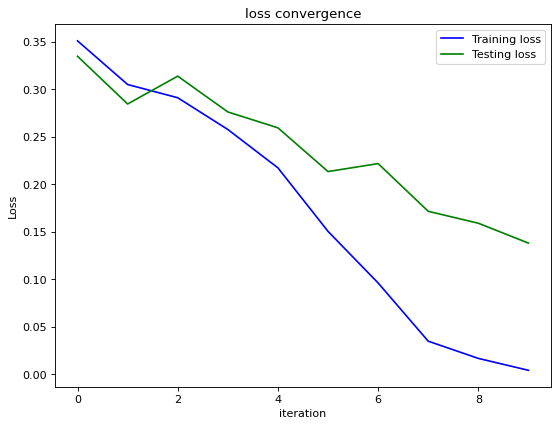

In [29]:
figure(figsize=(8, 6), dpi=80)
epochs = range(0,i-1)
plt.plot(epochs, totalErrorTrain, 'b', label='Training loss')
plt.plot(epochs, totalErrorTest, 'g', label='Testing loss')
plt.title('loss convergence')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
datafortest = dataFrameTest.iloc[0:10]
datafortest['prediction'] = decisionTreePredictions(dataFrameTest.iloc[0:10], decisionTree)
datafortest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive,prediction
463,0.5,0.0,0.5,1.0,1.0,1.0,0.0,0.0,0.0,1,0.0
760,0.5,1.0,1.0,0.5,0.5,0.0,0.5,1.0,1.0,0,0.0
326,0.5,1.0,0.5,1.0,1.0,0.0,0.0,1.0,0.5,1,1.0
571,0.0,0.5,0.5,0.5,0.0,1.0,1.0,1.0,1.0,1,1.0
180,1.0,0.5,0.5,0.0,1.0,0.5,0.0,1.0,1.0,1,1.0
906,0.0,1.0,0.5,0.0,0.0,0.5,1.0,1.0,0.5,0,0.0
149,1.0,0.5,0.5,1.0,1.0,0.5,1.0,0.5,1.0,1,1.0
449,0.5,0.0,1.0,0.0,1.0,0.0,1.0,0.5,0.0,1,1.0
755,0.5,1.0,1.0,0.5,0.5,1.0,0.0,1.0,0.5,0,0.0
578,0.0,0.5,0.0,1.0,1.0,1.0,0.5,0.0,0.0,1,1.0


accuracy is good, but we still have some error rate, for example **row463**